# Analysing chemical data from bills of materials
Use this notebook to explain what SnyOracle is and does in a specific ordered fashion

In [1]:
%colors nocolor

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

try:
    from synoracle import ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [3]:
with open('./processed_boms.json', 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

In [4]:
alldata = pd.DataFrame(columns=['pubchem_id','name', 'moles', 'synthesis_number'])
print(alldata)
for k,v in rawdata.items():
    placeholder = pd.DataFrame(eval(v)).reset_index().rename(columns={'index': 'pubchem_id'})
    placeholder['synthesis_number']=int(k)
    alldata = alldata.append(placeholder)

alldata['pubchem_id'] = alldata['pubchem_id'].astype(int)
display(alldata.head())

Empty DataFrame
Columns: [pubchem_id, name, moles, synthesis_number]
Index: []


,pubchem_id,name,moles,synthesis_number
0,702,[ethanol],0.000000,0
1,947,[nitrogen],0.000000,0
2,962,[H2O],1.101671,0
3,12749,[2-methylimidazole],0.002000,0
4,24821,[Co(NO3)2·6H2O],0.000500,0


In [5]:
def contains_element(pubchem_id: int, element_symbol: str) -> bool:
    entity = ingredients.ChemicalSpecies(alias=int(pubchem_id), property_cache_location='./cached_molecule_info.json')
    return element_symbol in entity.mol_formula

def substructure_compare(query_id, compare_id):
    from rdkit import Chem
    compare = ingredients.ChemicalSpecies(alias=int(compare_id), property_cache_location='./cached_molecule_info.json')
    query = ingredients.ChemicalSpecies(alias=int(query_id), property_cache_location='./cached_molecule_info.json')

    compare_chem = Chem.MolFromSmiles(compare.smiles)
    query_chem = Chem.MolFromSmiles(query.smiles)
    return query_chem.HasSubstructMatch(compare_chem)    

def contains_imidazole(pubchem_id: int) -> bool:
    return substructure_compare(pubchem_id, 795)

useful_ions = {
    'nitrate': 943,
    'sulfate': 1117,
    'acetate': 175,
    'chloride': 312,
    'oxide': 190217
}


In [6]:
with open('./chemical_typing_crossreference.json', 'r') as f:
    crossref = pd.DataFrame(json.load(f))
crossref.index = crossref.index.astype(int)

In [7]:
indices = list(alldata['pubchem_id'].unique())
for x in li_iterate(indices):
    try:
        if np.isnan(crossref.loc[x, 'contains_zinc']):
            print(x)
            for k,v in useful_ions.items():
                crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
            crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
            crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
            crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')
    except KeyError:
        print(x)
        for k,v in useful_ions.items():
            crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
        crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
        crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
        crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')

acids = [311, 313,612,944,  176, 243, 1004,1118, 1133,1152, 14917, 284, 
        1004, 6209, 6347, 7470, 7489, 8496, 11138, 25516, 25517, 
        71370, 517327, 3720192, 6097028]
bases = [1049,1146,129760994, 14797, 14798, 168937, 20586,
         222, 223,23675242, 24243, 243, 24436, 24540, 24654,3301, 5962,
        6115, 6224, 6341, 6503, 7497, 7504, 7618, 7852, 8007, 8102, 
        8111, 8471, 9033, 9237, 9321, 10005, 11107, 14923, 20586,
        24540, 168937, 517045, 2723810,23675242, 129760994 ]
amphoteric = [23663617, 283,943,961,1176, 14013]
surfactants = [5974, 8154, 14253, 2735067, 3423265, 5356789,
              5364713]
solvent_maps = [887, 962, 702, 6228, 6212, 1140, 174, 8028, 679, 8007, 6344, 8058, 3776, 5125, 12051]


crossref['contains_acid'] = crossref.index.isin([x for x in acids])
crossref['contains_base'] = crossref.index.isin([x for x in bases])
crossref['contains_amphoteric'] = crossref.index.isin([x for x in amphoteric])
crossref['contains_surfactant'] = crossref.index.isin([x for x in surfactants])
crossref['contains_solvent'] = crossref.index.isin([x for x in solvent_maps])


  0%|          | 0/407 [00:00<?, ?it/s]

In [8]:
crossref.head()

,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
702,False,False,False,False,False,False,False,False,False,False,False,False,True
947,False,False,False,False,False,False,False,False,False,False,False,False,False
962,False,False,False,False,False,False,False,False,False,False,False,False,True
12749,True,False,False,False,False,False,False,False,False,False,False,False,False
24821,False,True,False,False,False,False,False,True,False,False,False,False,False


In [9]:
crossref.to_json('./chemical_typing_crossreference.json')

In [10]:

alldata = pd.merge(alldata, crossref, left_on='pubchem_id', right_index=True)

In [11]:
by_chemicals = alldata.groupby('pubchem_id').aggregate({
    'name': sum, 
    'moles': max,
    'synthesis_number': lambda x: len(list(x)),
    'contains_imidazole': np.all,
    'contains_zinc': np.all,
    'contains_nitrate': np.all,
    'contains_sulfate': np.all,
    'contains_acetate': np.all,
    'contains_chloride': np.all,
    'contains_oxide': np.all,
    'contains_cobalt': np.all

}).sort_values(by='synthesis_number', ascending=False)

## Quantity analysis
Let's start by making a fresh dataframe to analyse

In [12]:
quant_analysis = alldata.sort_values('synthesis_number').reset_index()

In [13]:
zinc_quants = quant_analysis[quant_analysis['contains_zinc']]
max_zinc = zinc_quants.sort_values('moles', ascending=False).reset_index().head(10)
display(max_zinc)


,level_0,index,pubchem_id,name,moles,synthesis_number,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
0,7905,5,23994,[Zn],20.624120,1584,False,False,False,False,False,False,True,False,False,False,False,False,False
1,4532,2,23994,[zinc],0.773404,910,False,False,False,False,False,False,True,False,False,False,False,False,False
2,7862,1,11192,[Zn(CH3COO)2],0.620000,1576,False,False,False,True,False,False,True,False,False,False,False,False,False
3,6087,2,24518,[Zn(NO3)2],0.500000,1224,False,True,False,False,False,False,True,False,False,False,False,False,False
4,4582,3,15245636,"[ZIF-8, Zn(mIm)2]",0.439367,922,True,False,False,False,False,False,True,False,False,False,False,False,False
5,5963,3,24518,[Zn(NO3)2],0.350000,1200,False,True,False,False,False,False,True,False,False,False,False,False,False
6,5000,0,24518,[Zn(NO3)2],0.310000,1006,False,True,False,False,False,False,True,False,False,False,False,False,False
7,5002,0,24518,[Zn(NO3)2],0.310000,1007,False,True,False,False,False,False,True,False,False,False,False,False,False
8,2711,2,15865313,[zinc nitrate hexahydrate],0.282000,540,False,True,False,False,False,False,True,False,False,False,False,False,False
9,2100,3,15865313,[Zn(NO3)2·6H2O],0.200000,420,False,True,False,False,False,False,True,False,False,False,False,False,False


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,pubchem_id,name,moles,synthesis_number,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent,logmoles
2,3,12749,[2-methylimidazole],0.002000,0,True,False,False,False,False,False,False,False,False,False,False,False,False,-2.698970
12,1,12749,[2-methylimidazole],0.001583,2,True,False,False,False,False,False,False,False,False,False,False,False,False,-2.800519
16,2,12749,[mIM],0.023995,3,True,False,False,False,False,False,False,False,False,False,False,False,False,-1.619879
21,1,12749,[2-methylimidazole],0.005920,4,True,False,False,False,False,False,False,False,False,False,False,False,False,-2.227678
24,2,12749,[2-methylimidazole],0.008002,5,True,False,False,False,False,False,False,False,False,False,False,False,False,-2.096801


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


-1.8051362322652618
0.6663296731659301


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


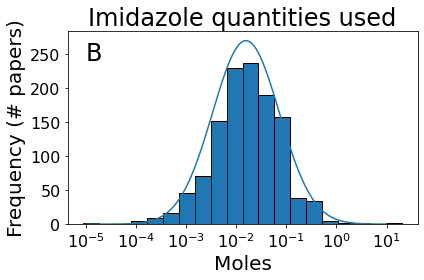

In [19]:
from scipy.stats import norm

imidazole_quants = quant_analysis[quant_analysis['contains_imidazole']]
data = imidazole_quants[(imidazole_quants['moles']>0)]
data['logmoles'] = data['moles'].apply(np.log10)
display(data.head())

mu, std = norm.fit(data['logmoles'])
print(mu)
print(std)
xvals = np.linspace(-5,1,100)
yvals = norm.pdf(xvals, mu, std)

fig, ax = plt.subplots()
sns.histplot(
    data = data,# imidazole_quants[(imidazole_quants['moles']>0)],
    x='logmoles', 
    ax=ax,
    #log_scale=True,
    bins=20,
    edgecolor='k',
    linewidth=1,
    alpha=1
)

sns.lineplot(x=xvals, y = 450*yvals)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=16)
ax.set_title('Imidazole quantities used', fontsize=24)
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_xlabel('Moles', fontsize=20)
ax.annotate('B', (-5, 240), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 3b.png', dpi=900)

c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.p

Zn: -2.544 +/- 0.615
Co: -2.530 +/- 0.569
Both: -2.540 +/- 0.600


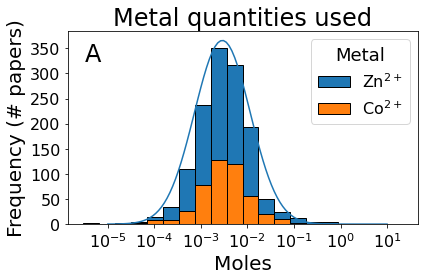

In [20]:
fig, ax = plt.subplots()
zinc_quants = quant_analysis[(quant_analysis['contains_zinc']) & (quant_analysis['moles']>0)]
cobalt_quants = quant_analysis[(quant_analysis['contains_cobalt']) & (quant_analysis['moles']>0)]

zinc_quants['logmoles'] = zinc_quants['moles'].apply(np.log10)
cobalt_quants['logmoles'] = cobalt_quants['moles'].apply(np.log10)

mu, std = norm.fit(zinc_quants['logmoles'])
print(f'Zn: {mu:.3f} +/- {std:.3f}')

mu, std = norm.fit(cobalt_quants['logmoles'])
print(f'Co: {mu:.3f} +/- {std:.3f}')

mu, std = norm.fit([*cobalt_quants['logmoles'], *zinc_quants['logmoles']])
print(f'Both: {mu:.3f} +/- {std:.3f}')


xvals = np.linspace(-5,1,100)
yvals = norm.pdf(xvals, mu, std)

data = pd.concat({'$\mathrm{Zn^{2+}}$': zinc_quants, '$\mathrm{Co^{2+}}$': cobalt_quants}).reset_index().sort_values(by='synthesis_number', ascending=False).rename({'level_0': 'Metal'}, axis=1)

sns.histplot(
    data = data,
    x='logmoles', 
    ax=ax,
    #log_scale=True,
    bins=20, 
    hue='Metal',
    multiple='stack',
    hue_order = ['$\\mathrm{Zn^{2+}}$', '$\\mathrm{Co^{2+}}$'],
    edgecolor='k',
    linewidth=1,
    alpha=1
)


legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['$\\mathrm{Zn^{2+}}$', '$\\mathrm{Co^{2+}}$'], title='Metal', fontsize=16, title_fontsize=18)


sns.lineplot(x=xvals, y = 550*yvals)


ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_xlabel('Moles', fontsize=20)
ax.set_title('Metal quantities used', fontsize=24)
ax.annotate('A', (-5.5, 325), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 3a.png', dpi=900)

In [16]:

mixed_metals = pd.concat({'zinc': zinc_quants, 'cobalt': cobalt_quants}).reset_index().sort_values(by='synthesis_number', ascending=False)
mixed_metals = mixed_metals.groupby('synthesis_number').aggregate({'level_0': set, 'moles':sum})
mixed_metals['level_0'] = mixed_metals['level_0'].astype(str)
mixed_metals = mixed_metals.replace({"{'zinc'}": 'Zn',"{'cobalt'}": 'Co',  "{'zinc', 'cobalt'}": 'mixed'})


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


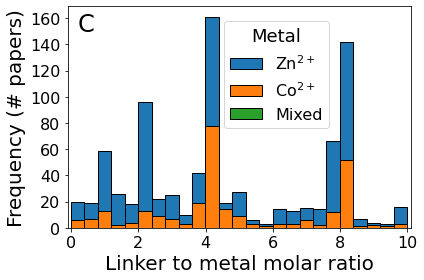

In [21]:
fig, ax = plt.subplots()

imidazole_ratio = imidazole_quants[['synthesis_number', 'moles']].rename({'moles': 'imidazole_moles'}, axis=1)
metal_ratio = pd.concat({'zinc': zinc_quants, 'cobalt': cobalt_quants}).reset_index()[['synthesis_number', 'level_0', 'moles']].rename({
    'moles': 'metal_moles',
    'level_0': 'metal_type'
}, axis=1)
stoichiometric_ratio = pd.merge(imidazole_ratio, mixed_metals.rename({
    'moles': 'metal_moles',
    'level_0': 'metal_type'
}, axis=1), on='synthesis_number')

stoichiometric_ratio['ratio'] = stoichiometric_ratio['imidazole_moles']/stoichiometric_ratio['metal_moles']

sns.histplot(
    data = stoichiometric_ratio[(stoichiometric_ratio['ratio']>0) & (stoichiometric_ratio['ratio']<10)],
    x='ratio',
    bins=25, 
    hue='metal_type',
    hue_order=['Zn','Co', 'mixed'],
    multiple='stack',
    ax=ax,
    edgecolor='k',
    linewidth=1,
    alpha=1
 )

ax.set_xlim([-0.1, 10.1])

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['$\\mathrm{Zn^{2+}}$', '$\\mathrm{Co^{2+}}$', 'Mixed'], title='Metal', fontsize=16, title_fontsize=18, loc=(0.455,0.45))

ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_xlabel('Linker to metal molar ratio', fontsize=20)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=16)

ax.annotate('C', (0.2, 150), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 3c.png', dpi=900)